# Interface Analysis

Analysis of the interfaces between Antibody and Antigens:

1. Average Size of Interface (number of residues in Ab and Ag)
2. Most prominent residues


In [8]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import scipy.spatial as sp
import warnings

warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_config, get_data_paths
#from abag_affinity.utils.pdb_processing import get_distances_and_info, antibody_chain
from abag_affinity.utils.pdb_reader import read_file

In [9]:
INTERFACE_DISTANCES = [5, 10]

In [10]:
config = read_config("../config.yaml")

summary_path, pdb_path = get_data_paths(config, "Dataset_v1")

pdb_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["AbDb"]["folder_path"], config["RESOURCES"]["AbDb"]["pdb_path"])

dataset = pd.read_csv(summary_path)

path = os.path.join(config["DATA"]["path"], config["DATA"]["Dataset_v1"]["folder_path"])

In [11]:
from abag_affinity.utils.pdb_processing import remove_redundant_chains
import string
alphabet_letters = set(string.ascii_lowercase)

def get_residue_count_and_interface_size(dataset, interface_distance_threshold):
    interface_sizes = []
    interface_resiude_count = {
        "antibody": defaultdict(int),
        "antigen": defaultdict(int)
    }
    
    resiude_count = {
        "antibody": defaultdict(int),
        "antigen": defaultdict(int)
    }


    no_antibody_antigen_contact = []

    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        pdb_id = row["pdb"]
        path = os.path.join(pdb_path, row["abdb_file"]) 
        structure, header = read_file(pdb_id, path)
        remove_redundant_chains(structure)
        
        chain_id2protein = {
            "l": "antibody", 
            "h": "antibody"
        }

        interface_count = {
            "antibody": [],
            "antigen": []
        }
        
        for chain_id in row["antibody_chains"]:
            chain_id2protein[chain_id.lower()] = "antibody"
        for chain_id in row["antigen_chains"]:
            chain_id2protein[chain_id.lower()] = "antigen"
            
        for letter in alphabet_letters - set(chain_id2protein.keys()):
            chain_id2protein[letter] = "antigen"


        residue_ca_coordinates = defaultdict(list)
        residue_n_coordinates = defaultdict(list)
        residue_c_coordinates = defaultdict(list)
        residue_o_coordinates = defaultdict(list)

        residue_name = defaultdict(list)

        for chain in structure.get_chains():
            for residue in chain.get_residues():
                if "CA" in residue:
                    residue_ca_coordinates[chain.id.lower()].append(residue["CA"].coord)
                else:
                    residue_ca_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "N" in residue:
                    residue_n_coordinates[chain.id.lower()].append(residue["N"].coord)
                else:
                    residue_n_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "C" in residue:
                    residue_c_coordinates[chain.id.lower()].append(residue["C"].coord)
                else:
                    residue_c_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "O" in residue:
                    residue_o_coordinates[chain.id.lower()].append(residue["O"].coord)
                else:
                    residue_o_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                residue_name[chain.id.lower()].append(residue.resname)
                resiude_count[chain_id2protein[chain.id.lower()]][residue.resname] += 1
        
        all_chains = list(structure.get_chains())
        for ii, chain in enumerate(all_chains):    
            for o_chain in all_chains[ii + 1:]:
                if chain_id2protein.get(chain.id.lower()) != chain_id2protein.get(o_chain.id.lower()) and len(residue_ca_coordinates[chain.id.lower()]) > 0 and len(residue_ca_coordinates[o_chain.id.lower()]) > 0 and chain_id2protein.get(chain.id.lower()) is not None and chain_id2protein.get(o_chain.id.lower()) is not None:
                    all_distances = []
                    for atom_coordinates in [residue_ca_coordinates,residue_n_coordinates,residue_c_coordinates,residue_o_coordinates]:
                        for o_atom_coordinates in [residue_ca_coordinates,residue_n_coordinates,residue_c_coordinates,residue_o_coordinates]:
                            all_distances.append(sp.distance_matrix(np.array(atom_coordinates[chain.id.lower()]), 
                                                                np.array(o_atom_coordinates[o_chain.id.lower()])))
                    
                    all_distances = np.stack(all_distances)
                    min_distances = np.amin(all_distances, axis=0)
                    
                    distances = sp.distance_matrix(np.array(residue_ca_coordinates[chain.id.lower()]), 
                                                                np.array(residue_ca_coordinates[o_chain.id.lower()]))

                    contacts = np.where(min_distances < interface_distance_threshold)
                    if len(contacts[0]) == 0:
                        continue
                    for res_contacts_id in np.unique(contacts[0]):
                        interface_resiude_count[chain_id2protein.get(chain.id.lower())][residue_name[chain.id.lower()][res_contacts_id]] += 1
                    for res_contacts_id in np.unique(contacts[1]):
                        interface_resiude_count[chain_id2protein.get(o_chain.id.lower())][residue_name[o_chain.id.lower()][res_contacts_id]] += 1

                    interface_count[chain_id2protein.get(chain.id.lower())].append(len(np.unique(contacts[0])))
                    interface_count[chain_id2protein.get(o_chain.id.lower())].append(len(np.unique(contacts[1])))
        if len(interface_count["antibody"]) == 0:
            no_antibody_antigen_contact.append(pdb_id)
        interface_sizes.append(interface_count)
        
        
    return interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact

In [12]:
interface_features = {}

for distance in INTERFACE_DISTANCES:
    interface_features[distance] = get_residue_count_and_interface_size(dataset, distance)

#interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = get_residue_count_and_interface_size(dataset, 10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [00:20<00:00, 20.32it/s]


### Analysis of Antibody & Antigen Binding Residues

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_binding_residues(interface_features):
    interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = interface_features
    plot_x_frequent = 20
    width = 0.4

    fix, ax = plt.subplots(2,1, figsize=(15,8))

    for i, protein in enumerate(interface_resiude_count.keys()):
        total_interface_contact_residues = sum(interface_resiude_count[protein].values())
        relative_interface_values = {res: count/total_interface_contact_residues * 100 for res, count in interface_resiude_count[protein].items()}

        total_contact_residues = sum(resiude_count[protein].values())
        relative_values = {res: count/total_contact_residues * 100 for res, count in resiude_count[protein].items()}

        sorted_dict = {k: v for k, v in sorted(relative_interface_values.items(), key=lambda item: item[1], reverse=True)}
        indices = np.arange(plot_x_frequent)
        most_frequent_aa = list(sorted_dict.keys())[:plot_x_frequent]

        interface_plot = ax[i].bar(indices, [relative_interface_values[aa] for aa in most_frequent_aa], width=width, align='center')
        protein_plot = ax[i].bar(indices + width, [relative_values[aa] for aa in most_frequent_aa], width=width, align='center')

        ax[i].set_xticks(indices + (width/2), list(sorted_dict.keys())[:plot_x_frequent])
        ax[i].set_title("{} most frequent residues of {} in contact".format(plot_x_frequent, protein))

        ax[i].set_ylabel("Relative Frequency (%)")

        interface_name = "paratope" if protein == "antibody" else "epitope"
        ax[i].legend( (interface_plot, protein_plot), (interface_name, protein) )

    plt.show()

Binding Residues for Distance Cutoff : 5


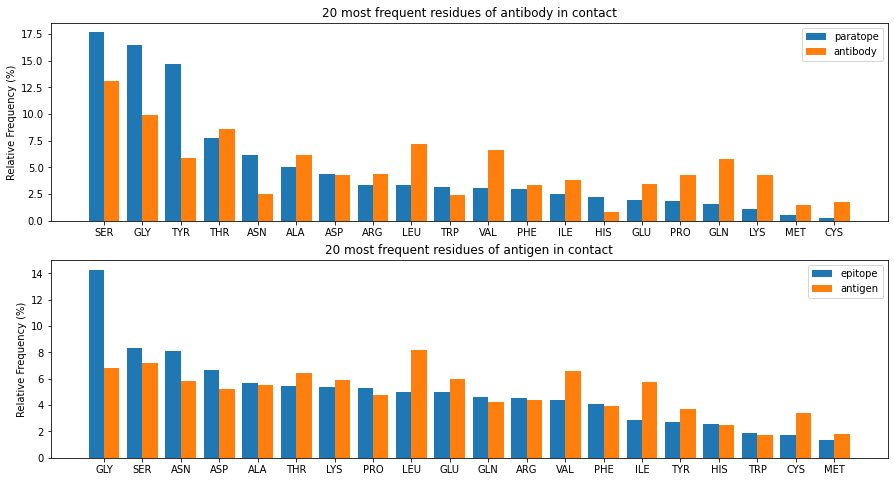

Binding Residues for Distance Cutoff : 10


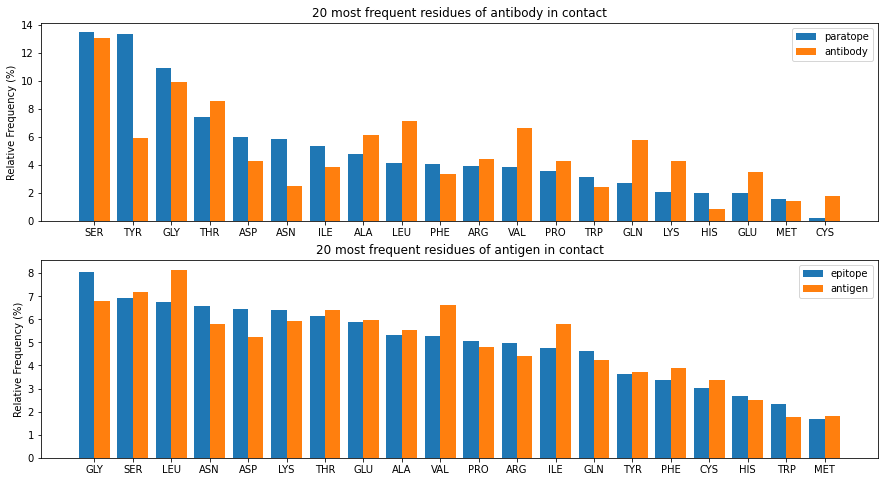

In [15]:
for distance in INTERFACE_DISTANCES:
    print("Binding Residues for Distance Cutoff :", distance)
    plot_binding_residues(interface_features[distance])

### Analysis of Interface Sizes

In [16]:
def calculate_interface_sizes(interface_features):
    interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = interface_features

    all_antibody_interfaces = []
    all_antigen_interfaces = []
    all_antibody_interface_size = []
    all_antigen_interface_size = []
    for interface_size in interface_sizes:
        for ab_interface_size in interface_size["antibody"]:
            all_antibody_interfaces.append(ab_interface_size)
        for ag_interface_size in interface_size["antigen"]:
            all_antigen_interfaces.append(ab_interface_size)
        all_antibody_interface_size.append(sum(interface_size["antibody"]))    
        all_antigen_interface_size.append(sum(interface_size["antigen"])) 
    print('Average size of an interface on the antibody >>> {:.4f} ({:.4f})'.format(np.mean(all_antibody_interfaces), np.std(all_antibody_interfaces)))
    print('Average size of an interface on the antigen >>> {:.4f} ({:.4f})'.format(np.mean(all_antigen_interfaces), np.std(all_antigen_interfaces)))
    print('Average size of the complete interface on the antibody >>> {:.4f} ({:.4f})'.format(np.mean(all_antibody_interface_size), np.std(all_antibody_interface_size)))
    print('Average size of the complete interface on the antigen >>> {:.4f} ({:.4f})'.format(np.mean(all_antigen_interface_size), np.std(all_antigen_interface_size)))
    print('Max size of the complete interface on the antibody >>> {:.0f}'.format(np.max(all_antibody_interface_size)))
    print('Max size of the complete interface on the antigen >>> {:.0f}'.format(np.max(all_antigen_interface_size)))

In [17]:
  for distance in INTERFACE_DISTANCES:
    print("Binding Residues for Distance Cutoff :", distance)
    calculate_interface_sizes(interface_features[distance])
    print()

Binding Residues for Distance Cutoff : 5
Average size of an interface on the antibody >>> 3.5693 (2.2971)
Average size of an interface on the antigen >>> 4.0030 (2.3997)
Average size of the complete interface on the antibody >>> 5.7990 (3.1693)
Average size of the complete interface on the antigen >>> 5.6925 (3.0357)
Max size of the complete interface on the antibody >>> 24
Max size of the complete interface on the antigen >>> 22

Binding Residues for Distance Cutoff : 10
Average size of an interface on the antibody >>> 19.9779 (8.6149)
Average size of an interface on the antigen >>> 23.7933 (7.4023)
Average size of the complete interface on the antibody >>> 41.6489 (11.3000)
Average size of the complete interface on the antigen >>> 39.7724 (17.7627)
Max size of the complete interface on the antibody >>> 113
Max size of the complete interface on the antigen >>> 113

